In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('psu_banks.csv', index_col=['date'])
prices.head(10)

SBIN.NS  BANKBARODA.NS    CANBK.NS      PNB.NS  UNIONBANK.NS  \
date                                                                          
01-01-2018  307.100006     161.500000  360.700012  169.750000    144.899994   
02-01-2018  303.250000     157.949997  352.049988  166.399994    141.949997   
03-01-2018  302.850006     157.850006  352.799988  166.600006    143.149994   
04-01-2018  308.500000     163.899994  362.549988  176.449997    147.500000   
05-01-2018  306.350006     161.800003  364.850006  176.000000    145.300003   
08-01-2018  305.799988     161.649994  364.750000  175.699997    145.649994   
09-01-2018  304.299988     164.500000  364.700012  174.649994    144.100006   
10-01-2018  301.100006     162.500000  354.649994  170.649994    141.750000   
11-01-2018  302.200012     163.300003  355.500000  172.750000    138.800003   
12-01-2018  302.250000     163.000000  353.950012  174.199997    137.600006   

            BANKINDIA.NS  INDIANB.NS     IOB.NS  CENTRALBK.NS  MAHABANK.NS  
date                                                                        
01-01-2018    169.899994  377.149994  22.450001     74.699997    23.299999  
02-01-2018    167.300003  375.549988  22.350000     74.949997    22.950001  
03-01-2018    168.350006  373.200012  22.500000     75.900002    23.049999  
04-01-2018    174.649994  380.149994  23.049999     76.750000    23.600000  
05-01-2018    172.250000  379.250000  24.150000     76.050003    23.650000  
08-01-2018    170.399994  380.700012  23.950001     75.449997    23.549999  
09-01-2018    170.250000  377.950012  23.950001     74.900002    23.250000  
10-01-2018    165.000000  373.450012  23.549999     74.699997    22.750000  
11-01-2018    166.050003  370.899994  23.350000     74.699997    22.450001  
12-01-2018    162.649994  374.250000  23.500000     75.000000    22.400000

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

SBIN.NS  BANKBARODA.NS    CANBK.NS      PNB.NS  UNIONBANK.NS  \
date                                                                          
01-01-2018  307.100006     161.500000  360.700012  169.750000    144.899994   
02-01-2018  303.250000     157.949997  352.049988  166.399994    141.949997   
30-12-2020  276.899994      62.099998  129.350006   32.750000     31.950001   
31-12-2020  274.950012      61.450001  128.949997   33.049999     31.549999   

            BANKINDIA.NS  INDIANB.NS     IOB.NS  CENTRALBK.NS  MAHABANK.NS  
date                                                                        
01-01-2018    169.899994  377.149994  22.450001     74.699997    23.299999  
02-01-2018    167.300003  375.549988  22.350000     74.949997    22.950001  
30-12-2020     49.200001   87.050003  10.500000     13.750000    13.050000  
31-12-2020     48.700001   85.699997  10.700000     13.850000    13.050000

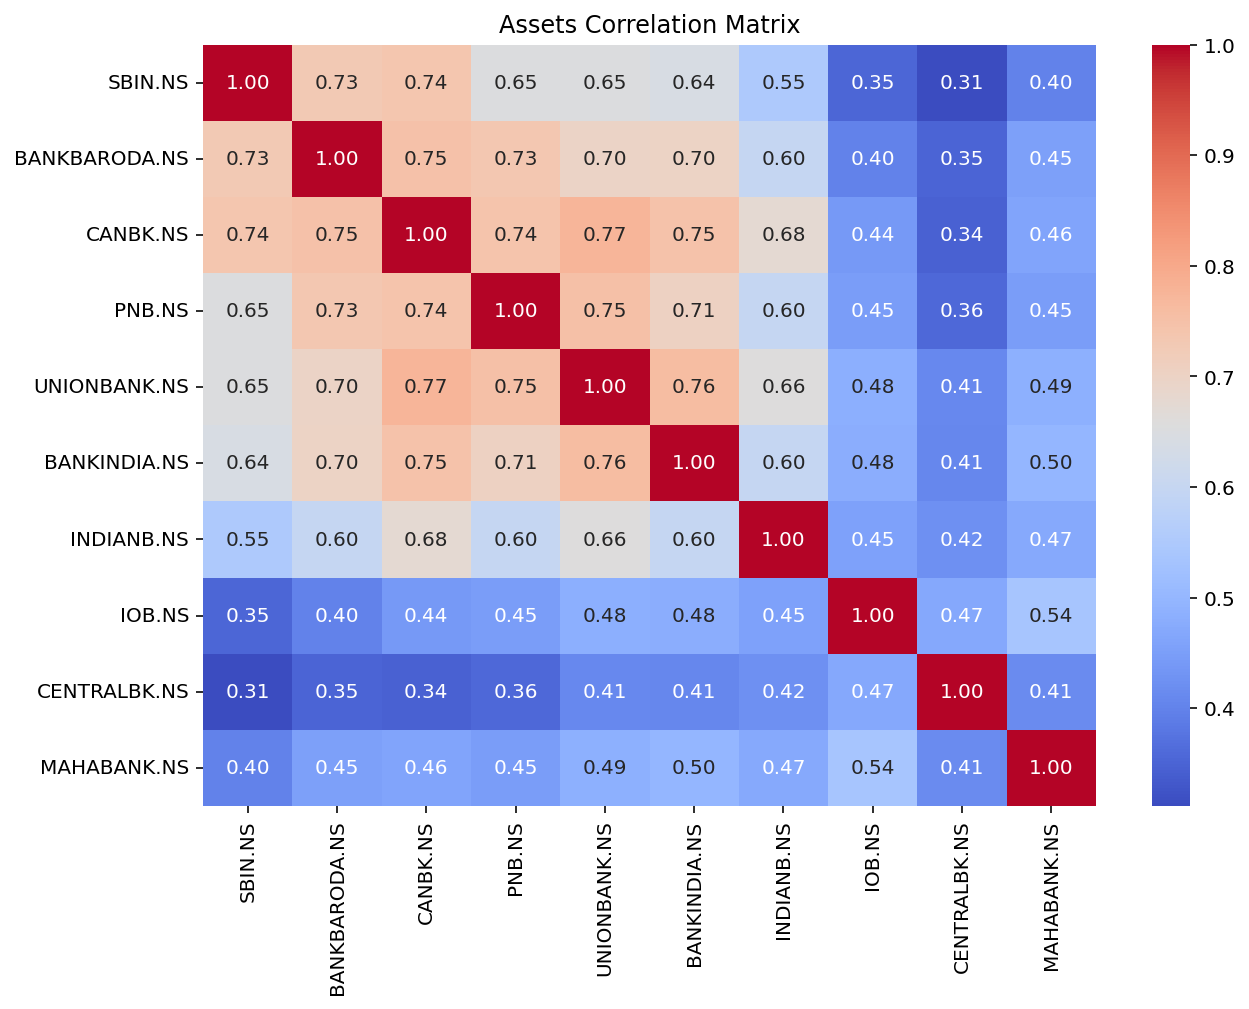

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('BANKBARODA.NS', 'UNIONBANK.NS'), ('BANKBARODA.NS', 'BANKINDIA.NS'), ('PNB.NS', 'UNIONBANK.NS'), ('PNB.NS', 'BANKINDIA.NS'), ('PNB.NS', 'INDIANB.NS'), ('PNB.NS', 'CENTRALBK.NS'), ('UNIONBANK.NS', 'BANKINDIA.NS'), ('UNIONBANK.NS', 'INDIANB.NS'), ('BANKINDIA.NS', 'INDIANB.NS')]


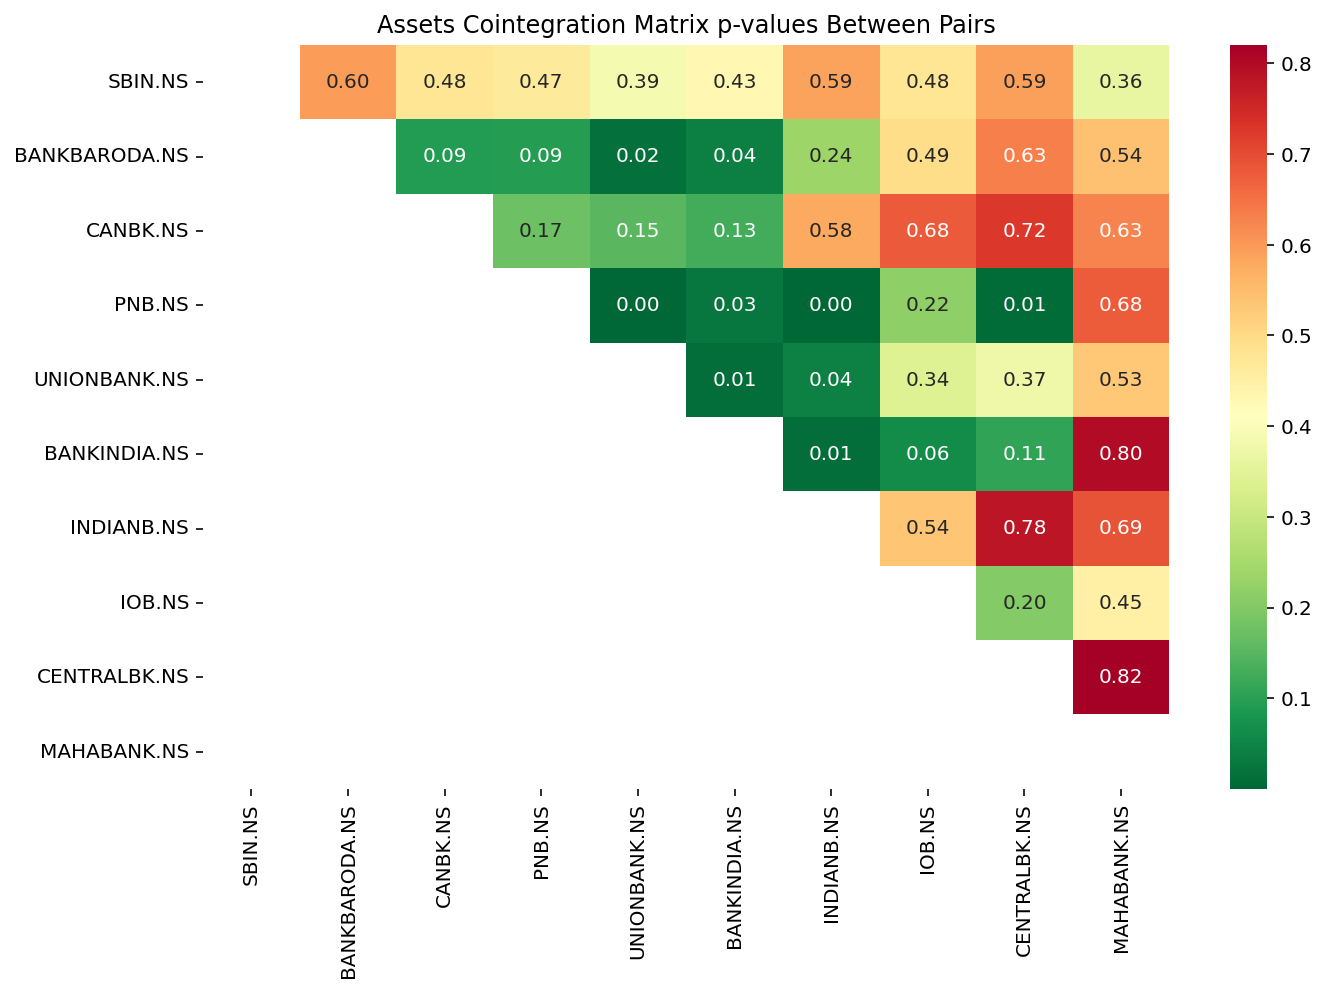

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'UNIONBANK.NS'
asset2 = 'INDIANB.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

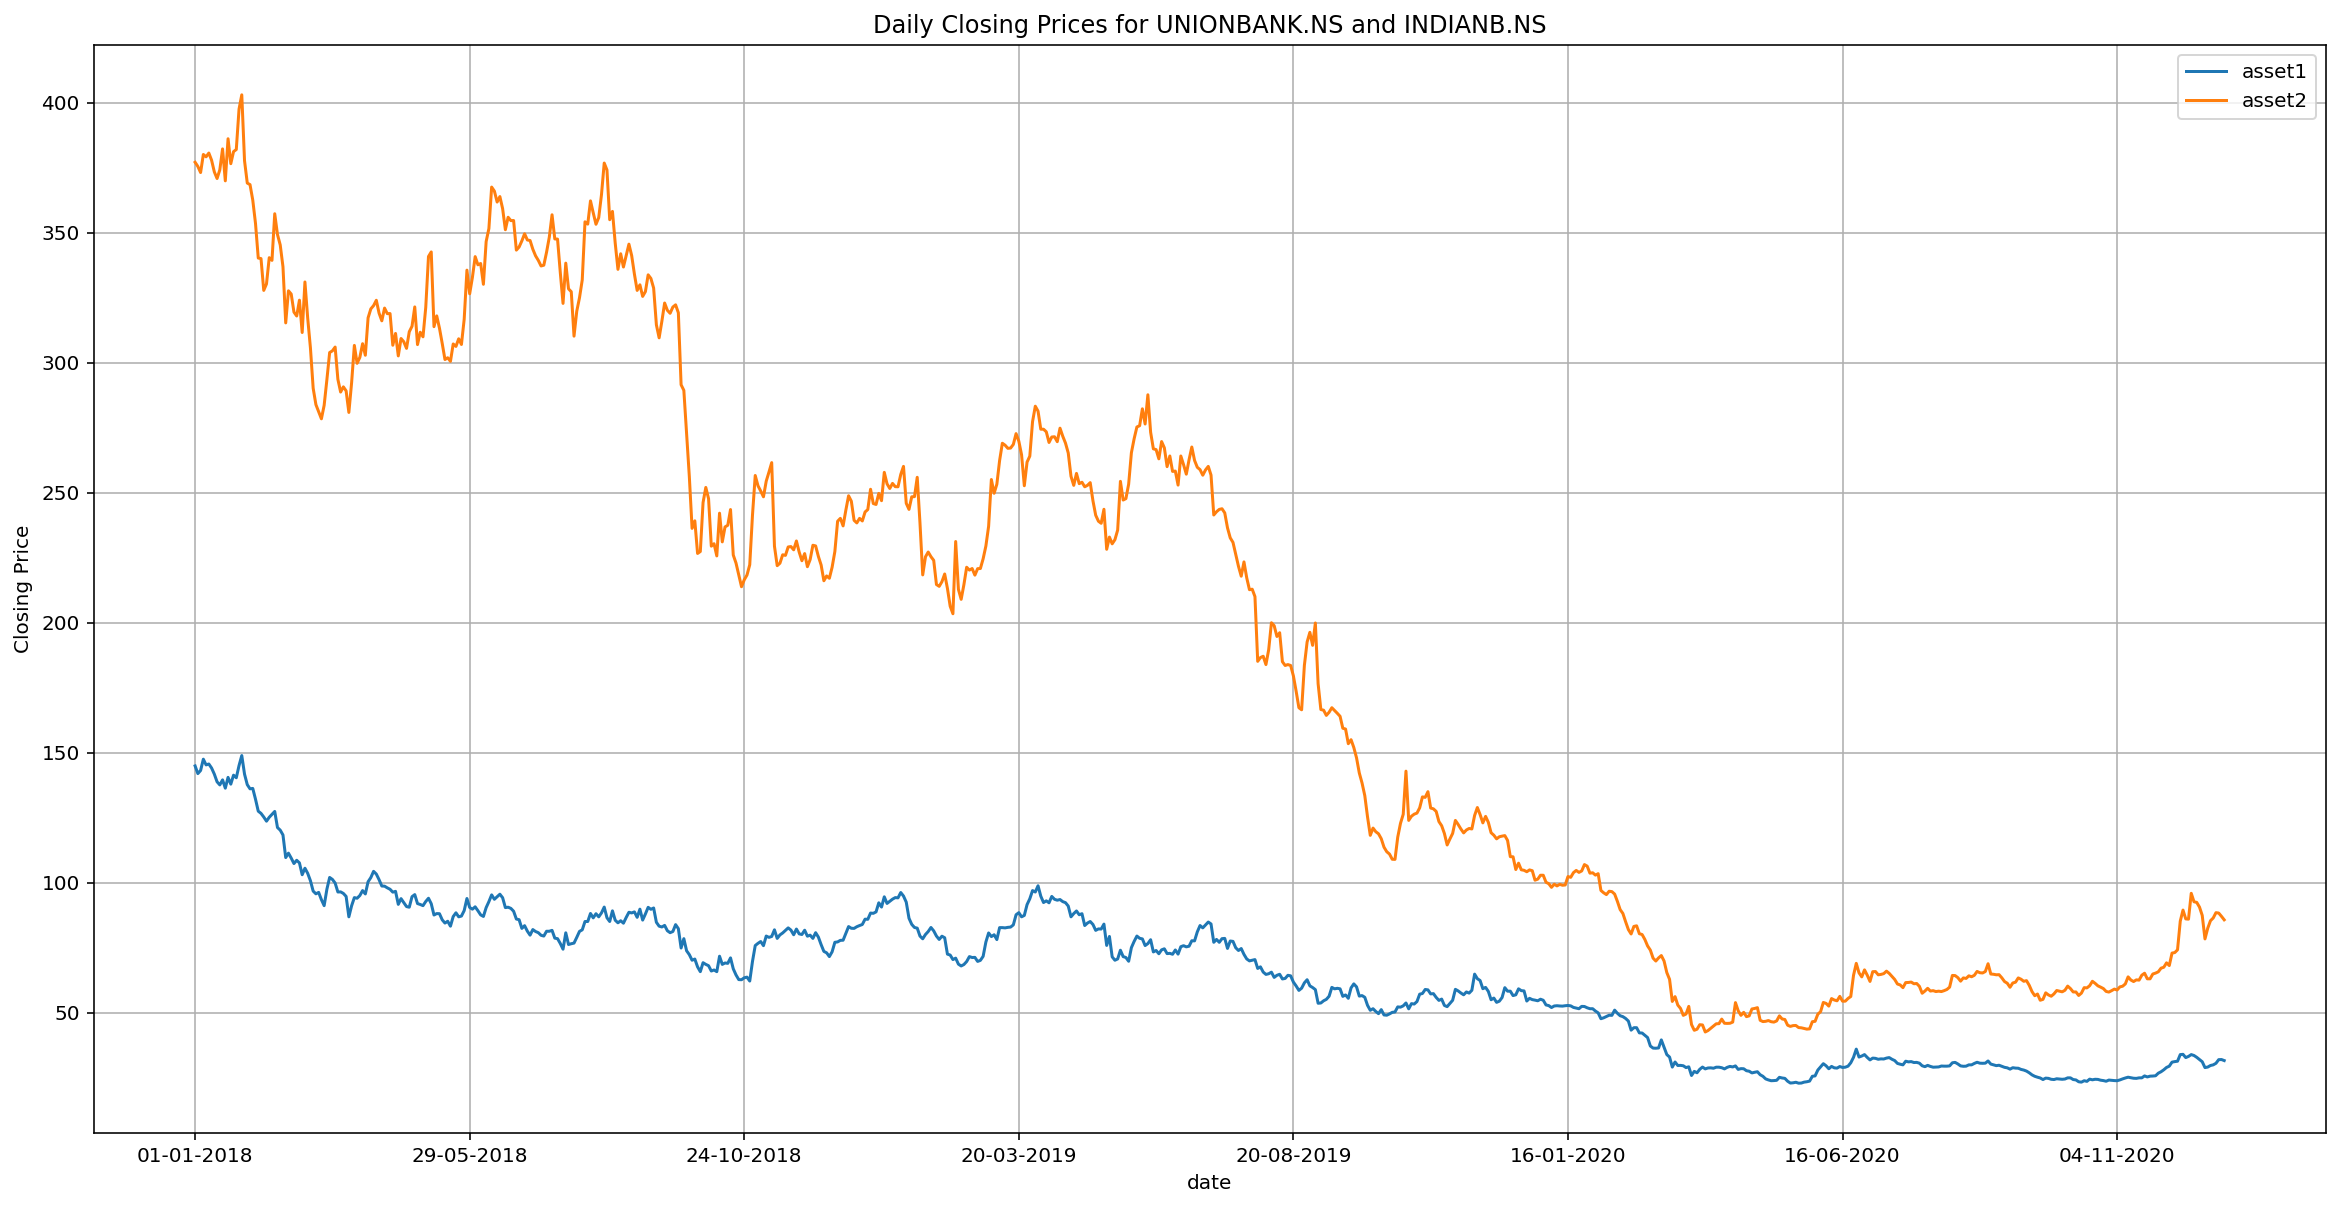

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                          2.082e+04
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:32:19   Log-Likelihood:                         -3792.3
No. Observations:                 740   AIC:                                      7587.
Df Residuals:                     739   BIC:                                      7591.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         3.0415      0.021    144.293      0.000       3.000       3.083
==============================================================================
Omnibus:                       87.262   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              116.438
Skew:                           0.956   Prob(JB):                     5.20e-26
Kurtosis:                       3.348   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

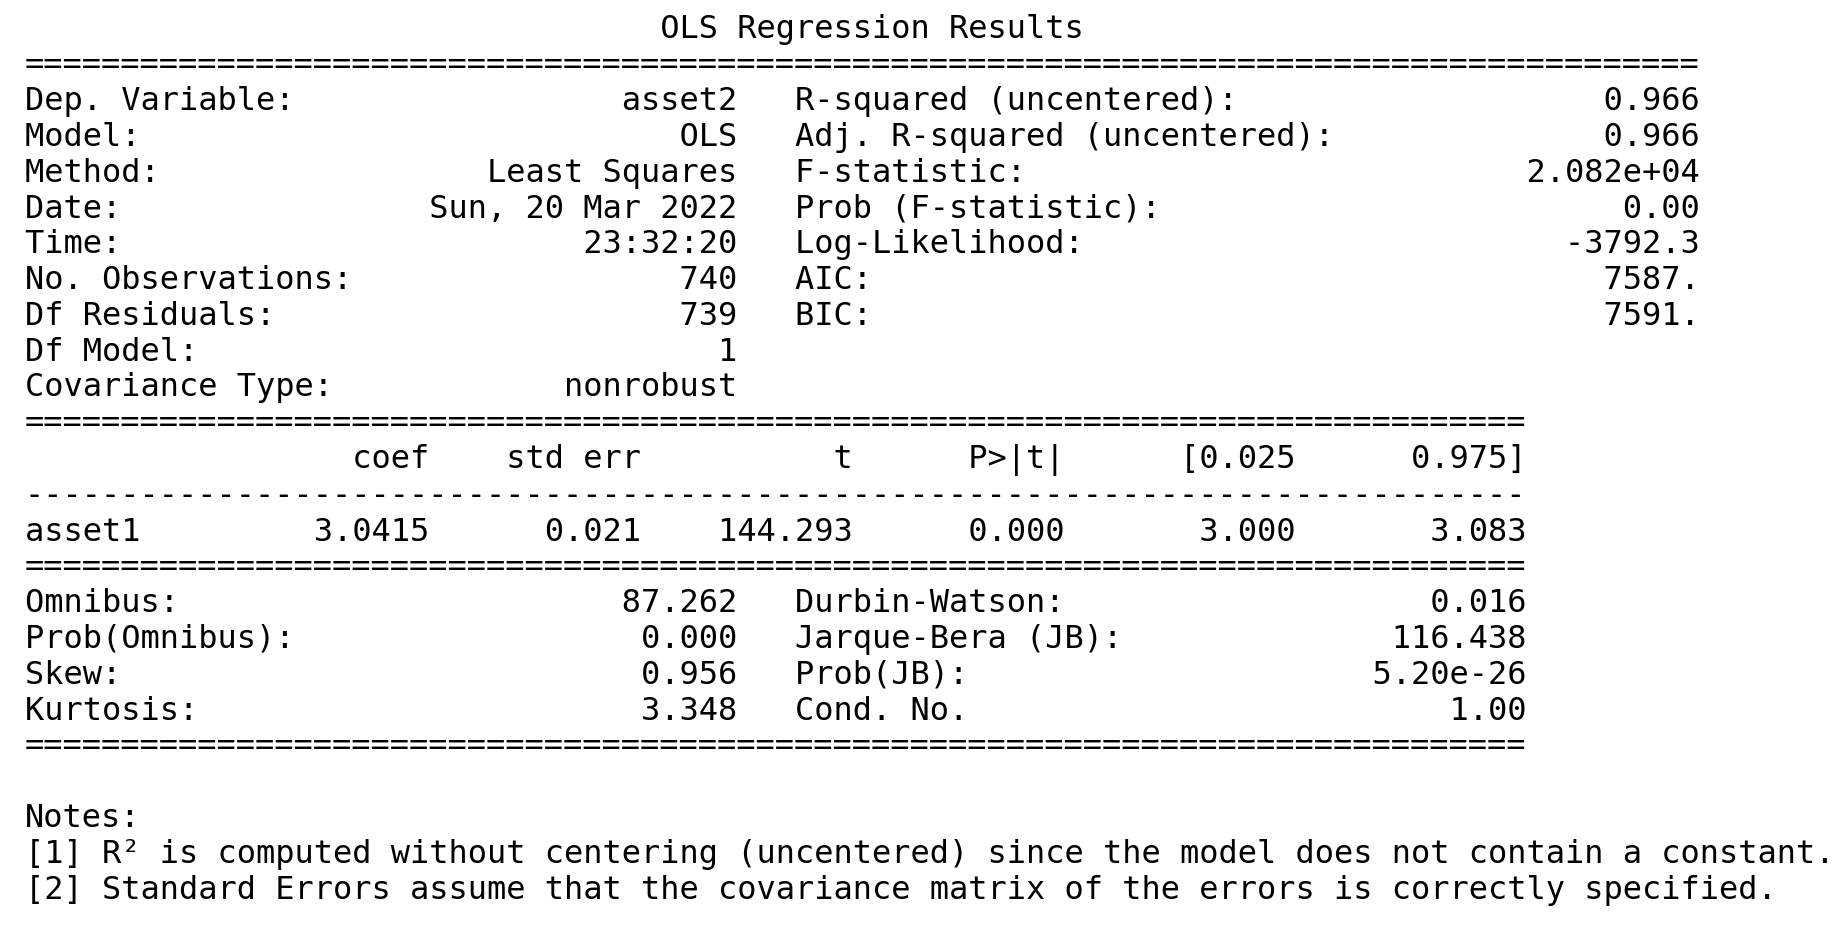

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  3.0415104879470114


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

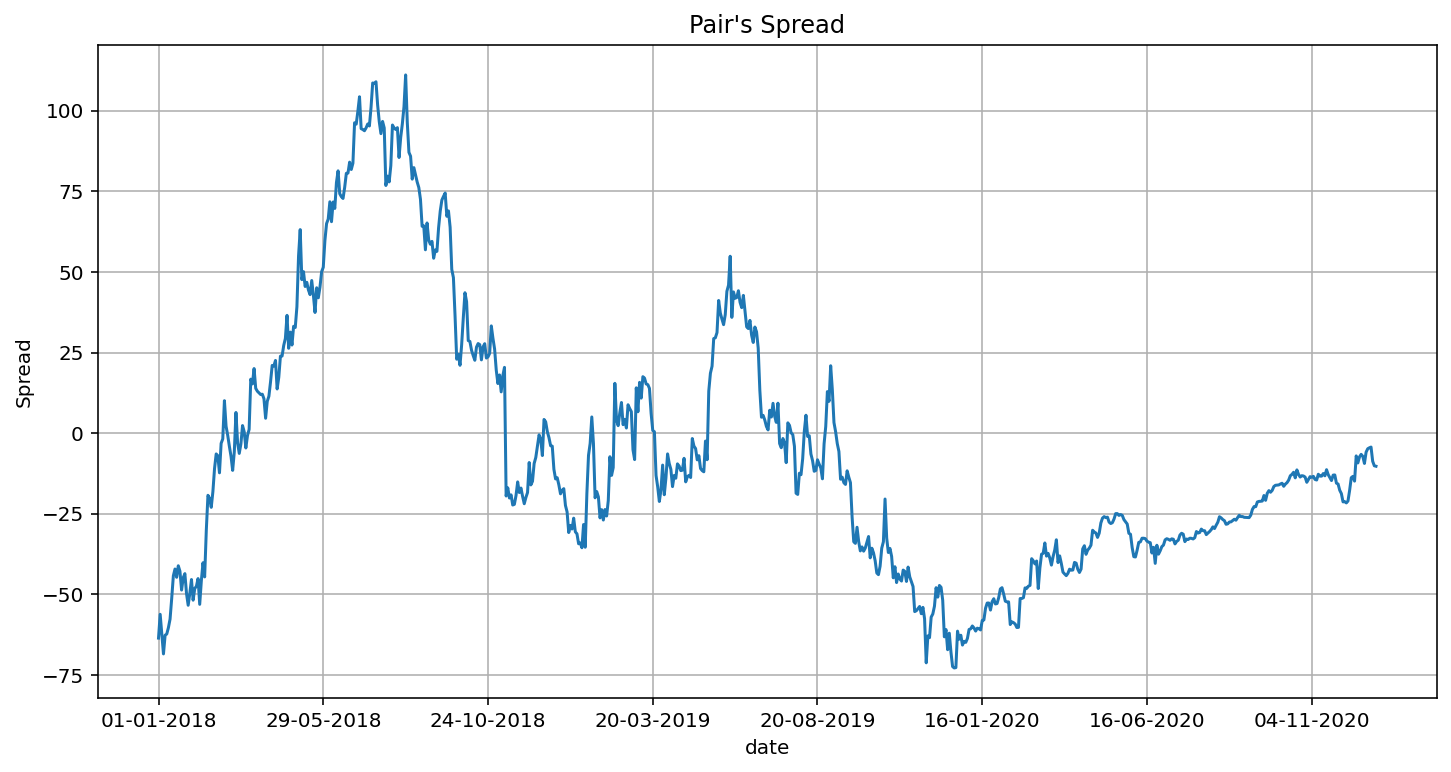

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-1.8741012369128083,
 0.3443410497249153,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 4507.380933865065)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -1.8741012369128083


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1     asset2
date                            
01-01-2021  32.099998  88.349998
04-01-2021  32.400002  88.699997
05-01-2021  32.049999  87.849998
06-01-2021  31.850000  87.750000
07-01-2021  31.900000  87.349998

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1     asset2         z  z upper limit  z lower limit
date                                                                    
01-01-2021  32.099998  88.349998  2.621114            1.0           -1.0
04-01-2021  32.400002  88.699997  2.689680            1.0           -1.0
05-01-2021  32.049999  87.849998  2.673851            1.0           -1.0
06-01-2021  31.850000  87.750000  2.608281            1.0           -1.0
07-01-2021  31.900000  87.349998  2.686909            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

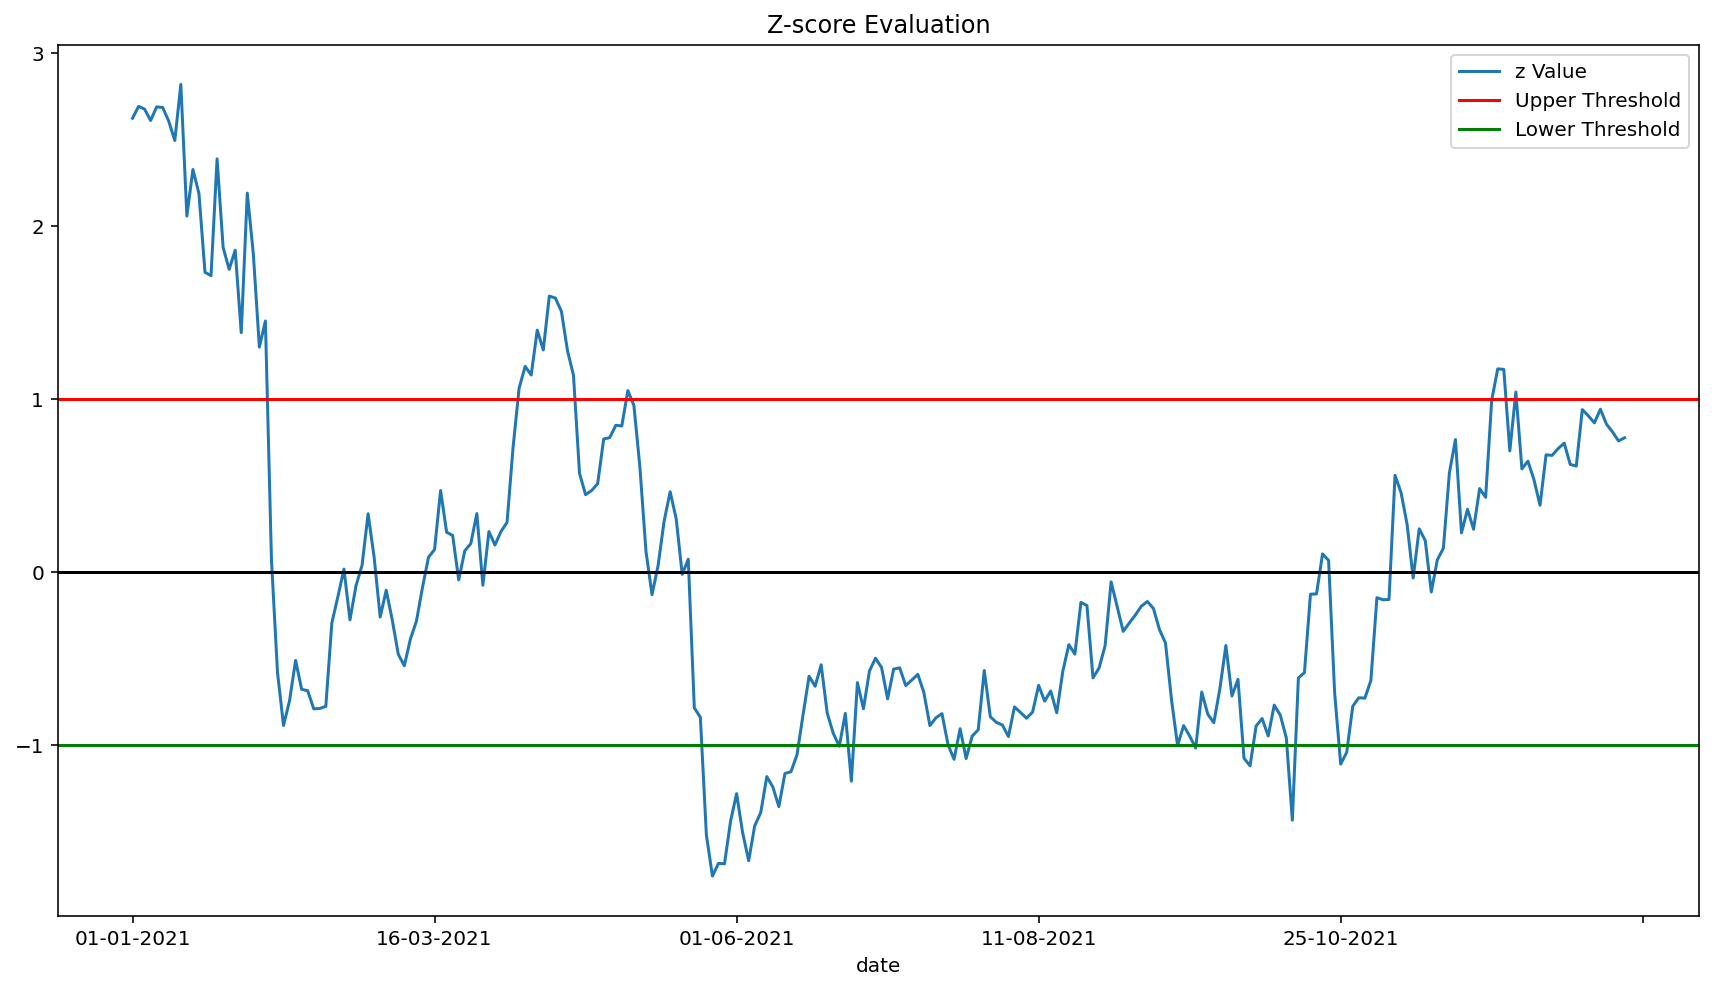

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  32.099998   88.349998  2.621114            1.0           -1.0   
04-01-2021  32.400002   88.699997  2.689680            1.0           -1.0   
05-01-2021  32.049999   87.849998  2.673851            1.0           -1.0   
29-12-2021  43.549999  139.649994  0.809752            1.0           -1.0   
30-12-2021  42.799999  137.899994  0.757631            1.0           -1.0   
31-12-2021  43.400002  139.600006  0.775873            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1     asset2         z  z upper limit  z lower limit  \
date                                                                       
01-01-2021  32.099998  88.349998  2.621114            1.0           -1.0   
04-01-2021  32.400002  88.699997  2.689680            1.0           -1.0   
05-01-2021  32.049999  87.849998  2.673851            1.0           -1.0   
06-01-2021  31.850000  87.750000  2.608281            1.0           -1.0   
07-01-2021  31.900000  87.349998  2.686909            1.0           -1.0   
08-01-2021  31.799999  87.099998  2.683394            1.0           -1.0   
11-01-2021  31.350000  86.400002  2.604208            1.0           -1.0   
12-01-2021  33.000000  91.750000  2.492514            1.0           -1.0   
13-01-2021  33.200001  90.000000  2.816803            1.0           -1.0   
14-01-2021  33.200001  95.599998  2.056440            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
08-01-2021        -1         0.0         1         0.0  
11-01-2021        -1         0.0         1         0.0  
12-01-2021        -1         0.0         1         0.0  
13-01-2021        -1         0.0         1         0.0  
14-01-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  32.099998   88.349998  2.621114            1.0           -1.0   
04-02-2021  34.549999  118.750000  0.074192            1.0           -1.0   
07-04-2021  36.799999  115.349998  1.062331            1.0           -1.0   
23-04-2021  32.700001  107.199997  0.569990            1.0           -1.0   
05-05-2021  36.500000  114.550003  1.048576            1.0           -1.0   
27-10-2021  50.549999  189.449997 -0.774626            1.0           -1.0   
02-12-2021  46.299999  143.699997  1.173877            1.0           -1.0   
06-12-2021  44.750000  144.949997  0.699828            1.0           -1.0   
07-12-2021  46.549999  146.199997  1.040177            1.0           -1.0   
08-12-2021  47.000000  153.699997  0.596493            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-02-2021         0         1.0         0        -1.0  
07-04-2021        -1        -1.0         1         1.0  
23-04-2021         0         1.0         0        -1.0  
05-05-2021        -1        -1.0         1         1.0  
27-10-2021         0        -1.0         0         1.0  
02-12-2021        -1        -1.0         1         1.0  
06-12-2021         0         1.0         0        -1.0  
07-12-2021        -1        -1.0         1         1.0  
08-12-2021         0         1.0         0        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

34.549999    1
32.700001    1
36.000000    1
35.000000    1
38.349998    1
39.349998    1
36.150002    1
36.049999    1
34.849998    1
34.599998    1
36.250000    1
39.650002    1
48.299999    1
44.750000    1
47.000000    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                        
01-01-2021  32.099998   88.349998  2.621114            1.0           -1.0   
04-01-2021  32.400002   88.699997  2.689680            1.0           -1.0   
05-01-2021  32.049999   87.849998  2.673851            1.0           -1.0   
06-01-2021  31.850000   87.750000  2.608281            1.0           -1.0   
07-01-2021  31.900000   87.349998  2.686909            1.0           -1.0   
...               ...         ...       ...            ...            ...   
27-12-2021  42.950001  136.100006  0.940853            1.0           -1.0   
28-12-2021  44.150002  141.000000  0.854424            1.0           -1.0   
29-12-2021  43.549999  139.649994  0.809752            1.0           -1.0   
30-12-2021  42.799999  137.899994  0.757631            1.0           -1.0   
31-12-2021  43.400002  139.600006  0.775873            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

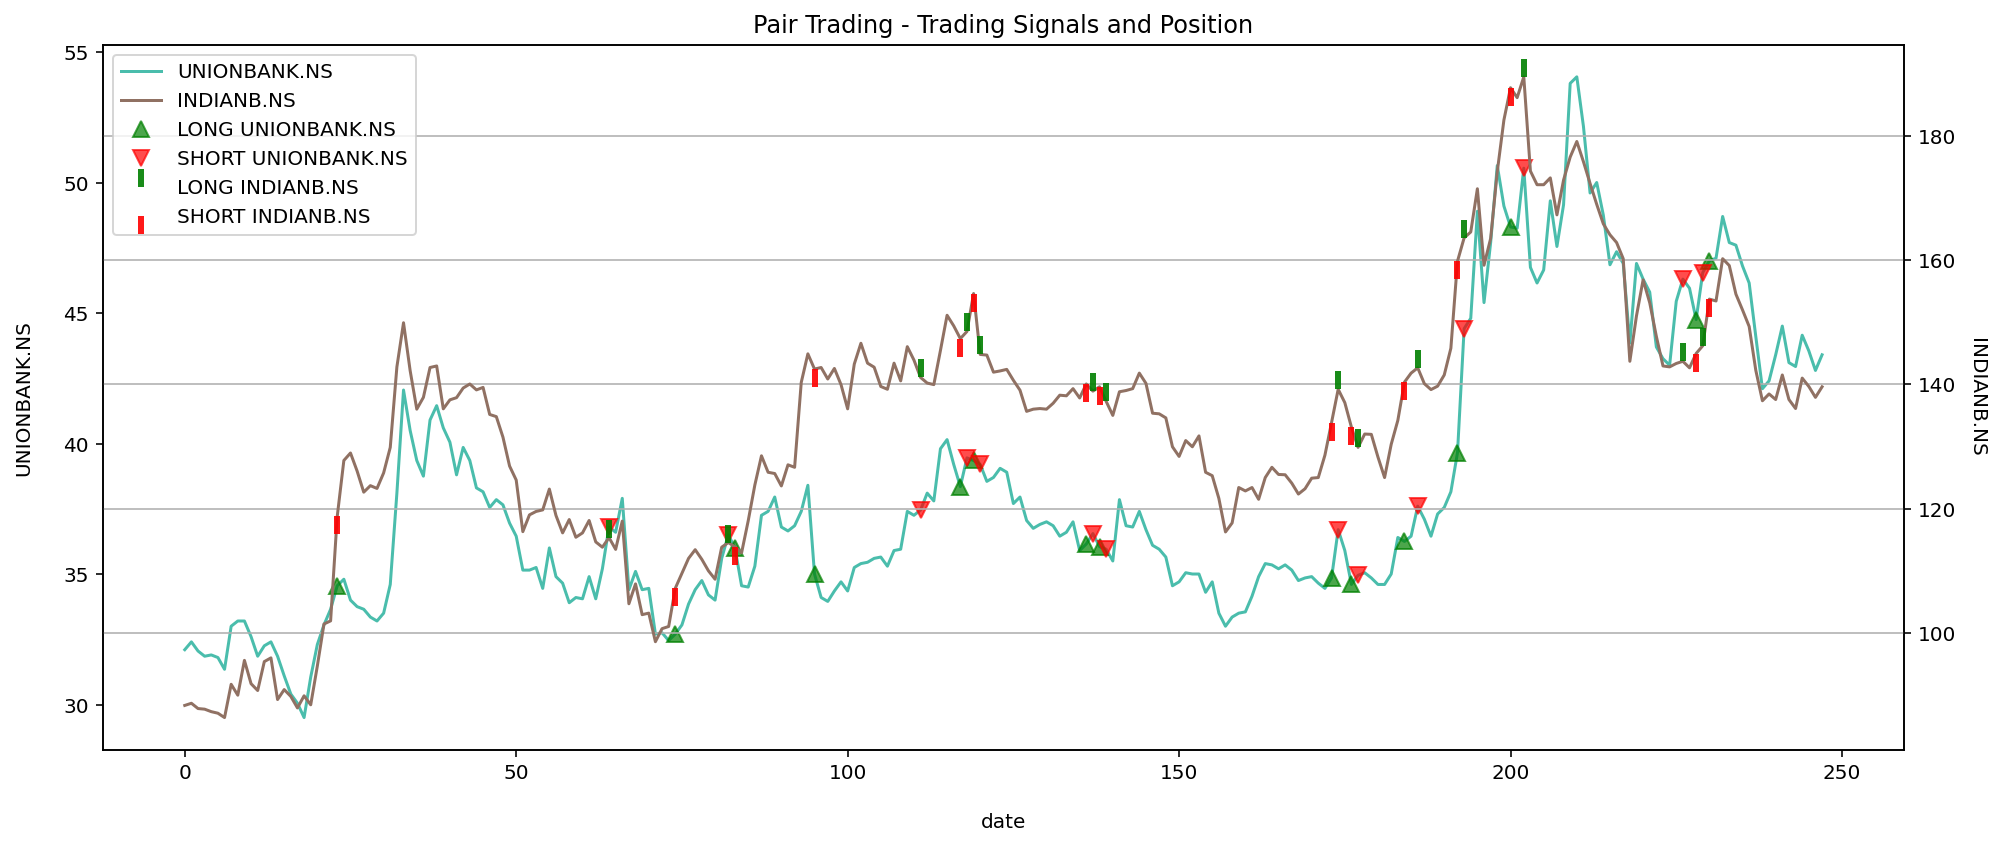

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    32.099998           NaN            NaN            NaN       NaN   
1    32.400002      0.000000  100000.000000  100000.000000       NaN   
2    32.049999      0.000000  100000.000000  100000.000000  0.000000   
3    31.850000      0.000000  100000.000000  100000.000000  0.000000   
4    31.900000      0.000000  100000.000000  100000.000000  0.000000   
243  42.950001  79457.501406   72990.009879  152447.511285 -0.001817   
244  44.150002  81677.502831   72990.009879  154667.512710  0.014562   
245  43.549999  80567.498594   72990.009879  153557.508473 -0.007177   
246  42.799999  79179.998594   72990.009879  152170.008473 -0.009036   
247  43.400002  80290.002831   72990.009879  153280.012710  0.007295   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   32.099998           NaN            NaN            NaN       NaN   
23  34.549999  63917.498594   36082.501406  100000.000000  0.000000   
64  36.799999      0.000000  104162.500000  104162.500000  0.029248   
74  32.700001  60495.001406   43667.498594  104162.500000  0.000000   
82  36.500000      0.000000  111192.498594  111192.498594  0.015202   

    positions1  
0          NaN  
23         1.0  
64        -1.0  
74         1.0  
82        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    32.099998           NaN            NaN            NaN       NaN   
1    32.400002      0.000000  100000.000000  100000.000000       NaN   
2    32.049999      0.000000  100000.000000  100000.000000  0.000000   
3    31.850000      0.000000  100000.000000  100000.000000  0.000000   
4    31.900000      0.000000  100000.000000  100000.000000  0.000000   
243  42.950001  79457.501406   72990.009879  152447.511285 -0.001817   
244  44.150002  81677.502831   72990.009879  154667.512710  0.014562   
245  43.549999  80567.498594   72990.009879  153557.508473 -0.007177   
246  42.799999  79179.998594   72990.009879  152170.008473 -0.009036   
247  43.400002  80290.002831   72990.009879  153280.012710  0.007295   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN   88.349998           NaN            NaN            NaN   
1           0.0   88.699997      0.000000  100000.000000  100000.000000   
2           0.0   87.849998      0.000000  100000.000000  100000.000000   
3           0.0   87.750000      0.000000  100000.000000  100000.000000   
4           0.0   87.349998      0.000000  100000.000000  100000.000000   
243         0.0  136.100006 -71724.703215  164425.766021   92701.062806   
244         0.0  141.000000 -74307.000000  164425.766021   90118.766021   
245         0.0  139.649994 -73595.546785  164425.766021   90830.219235   
246         0.0  137.899994 -72673.296785  164425.766021   91752.469235   
247         0.0  139.600006 -73569.203215  164425.766021   90856.562806   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.008312         0.0  
244 -0.027856         0.0  
245  0.007895         0.0  
246  0.010154         0.0  
247 -0.009764         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   32.099998           NaN            NaN            NaN       NaN   
23  34.549999  63917.498594   36082.501406  100000.000000  0.000000   
64  36.799999      0.000000  104162.500000  104162.500000  0.029248   
74  32.700001  60495.001406   43667.498594  104162.500000  0.000000   
82  36.500000      0.000000  111192.498594  111192.498594  0.015202   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN   88.349998           NaN            NaN            NaN   
23         1.0  118.750000 -62581.250000  162581.250000  100000.000000   
64        -1.0  115.349998      0.000000  101791.800790  101791.800790   
74         1.0  107.199997 -56494.398366  158286.199157  101791.800790   
82        -1.0  114.550003      0.000000   97918.347523   97918.347523   

         return2  positions2  
0            NaN         NaN  
23  0.000000e+00        -1.0  
64 -7.960806e-03         1.0  
74 -1.110223e-16        -1.0  
82 -4.020298e-03         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

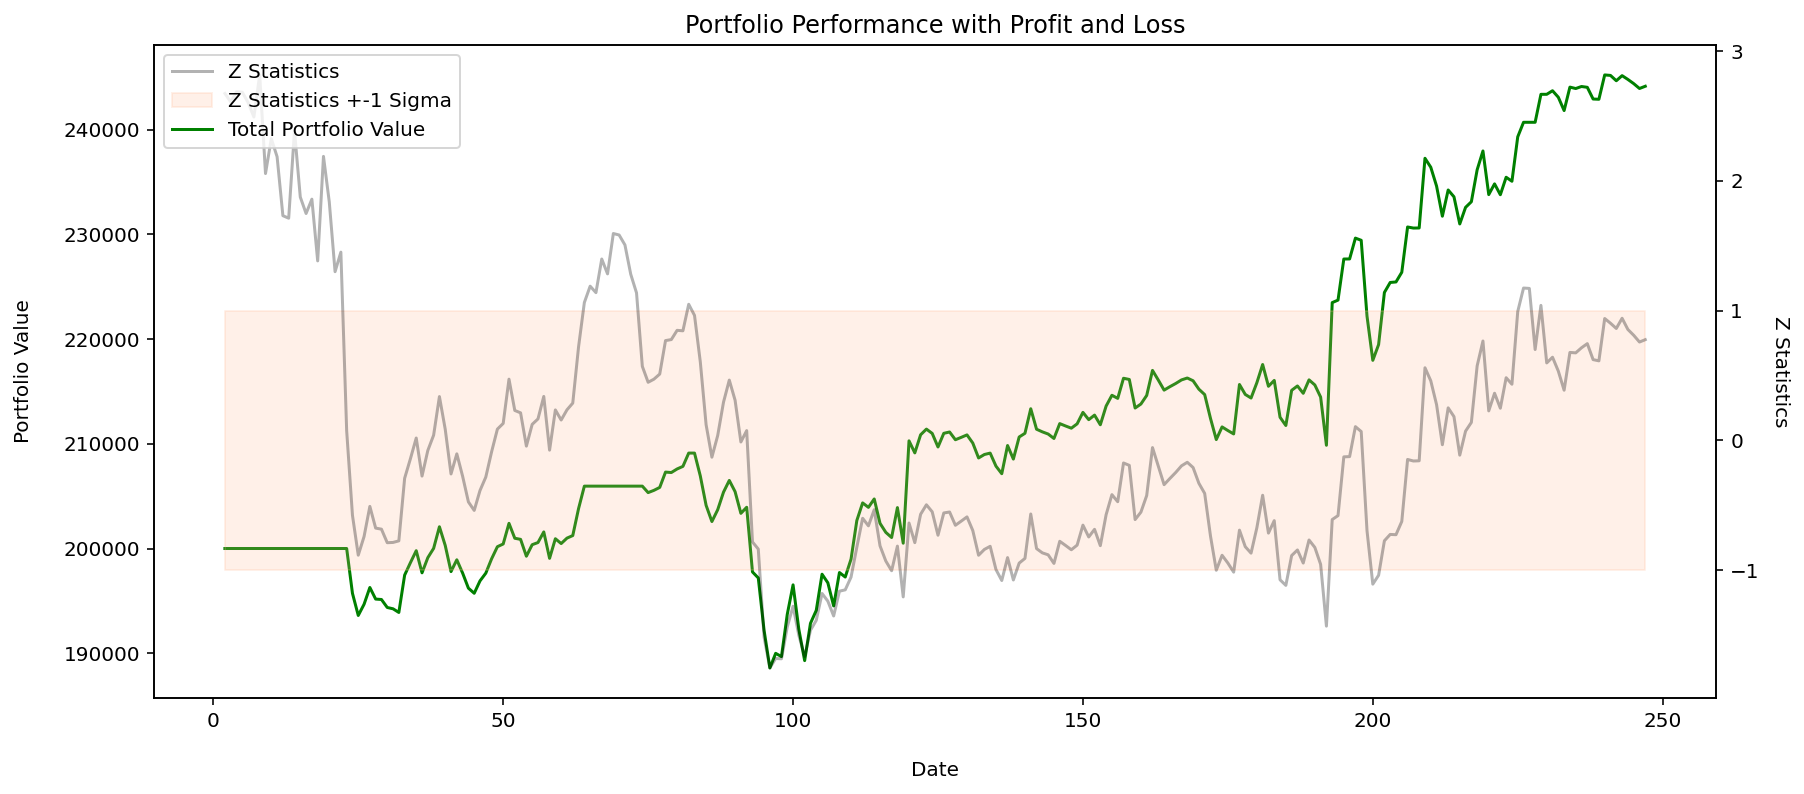

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

244136.57551559998

In [48]:
profit = final_portfolio - 2*initial_capital
profit

44136.57551559998

In [49]:
roi = (profit / (2*initial_capital))*100
roi

22.06828775779999

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 278.002%
